**Import necessary Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, make_scorer, top_k_accuracy_score

import pickle
import gradio as gr

**I will now create a single dataset which will contain all necessary features using various csv files.**
1. Firstly we will take Driver Details & Starting Grids dataset as it has details about various F1 drivers. 

In [6]:
df2 = pd.read_csv(r'\driver_details.csv')
df13 = pd.read_csv(r'\starting_grids.csv')

In [7]:
df13.head()

,Car,Detail,Driver,DriverCode,Grand Prix,No,Pos,Time,Year
0,Alfa Romeo,Starting-Grid,Juan Manuel Fangio,FAN,Monaco,34,1,1:50.200,1950
1,Alfa Romeo,Starting-Grid,Nino Farina,FAR,Monaco,32,2,NaN,1950
2,Maserati,Starting-Grid,Jose Froilan Gonzalez,GON,Monaco,2,3,NaN,1950
3,Talbot-Lago,Starting-Grid,Philippe Etancelin,ETA,Monaco,14,4,NaN,1950
4,Alfa Romeo,Starting-Grid,Luigi Fagioli,FAG,Monaco,36,5,NaN,1950


Lets merge these two dataframes & drop irrelevant columns.

In [8]:
#I have kept how = right, because df13 has more number of rows.
newdf2_13 = df2.merge(df13, how= 'right', on= ['Car', 'Driver', 'Grand Prix', 'Year'])

newdf2_13.drop(['Time', 'No', 'Detail'], axis= 1, inplace= True)
newdf2_13.rename(columns= {'PTS':'Finish_Position_PTS', 'Pos': 'Starting_Position', 'Race Position':'Finish_Position'}, inplace= True)

In [9]:
newdf2_13.head()

,Car,Date,Driver,Grand Prix,Finish_Position_PTS,Finish_Position,Year,DriverCode,Starting_Position
0,Alfa Romeo,21-May-50,Juan Manuel Fangio,Monaco,9.0,1,1950,FAN,1
1,Alfa Romeo,21-May-50,Nino Farina,Monaco,0.0,DNF,1950,FAR,2
2,Maserati,NaN,Jose Froilan Gonzalez,Monaco,NaN,NaN,1950,GON,3
3,Talbot-Lago,21-May-50,Philippe Etancelin,Monaco,0.0,DNF,1950,ETA,4
4,Alfa Romeo,21-May-50,Luigi Fagioli,Monaco,0.0,DNF,1950,FAG,5


2. Now lets incorporate race details for each driver for each grand prix.

In [10]:
df9 = pd.read_csv(r'\race_details.csv')

In [11]:
newdf2_13_9 = newdf2_13.merge(df9, how= 'inner', on= ['Car', 'Driver', 'Grand Prix', 'Year'])

In [12]:
newdf2_13_9.drop(['DriverCode_x', 'DriverCode_y', 'No', 'Detail','Finish_Position','Finish_Position_PTS', 'Time/Retired'], axis= 1, inplace= True)

newdf2_13_9.rename(columns= {'Pos':'Finish_Position', 'PTS':'Finish_Position_PTS'}, inplace= True)

In [13]:
newdf2_13_9.head()

,Car,Date,Driver,Grand Prix,Year,Starting_Position,Finish_Position,Laps,Finish_Position_PTS
0,Alfa Romeo,21-May-50,Juan Manuel Fangio,Monaco,1950,1,1,100.0,9.0
1,Alfa Romeo,21-May-50,Nino Farina,Monaco,1950,2,NC,0.0,0.0
2,Maserati,NaN,Jose Froilan Gonzalez,Monaco,1950,3,NC,1.0,0.0
3,Talbot-Lago,21-May-50,Philippe Etancelin,Monaco,1950,4,NC,36.0,0.0
4,Alfa Romeo,21-May-50,Luigi Fagioli,Monaco,1950,5,NC,0.0,0.0


3. We will add the qualifying dataset which will have details for qualifying for every driver.

In [14]:
df8 = pd.read_csv(r'\qualifyings.csv')

In [15]:
newdf2_13_9_8 = newdf2_13_9.merge(df8, how = 'inner', on= ['Car', 'Driver', 'Grand Prix', 'Year'])

In [17]:
newdf2_13_9_8.drop(['DriverCode', 'Date', 'Laps_x', 'Laps_y', 'Detail', 'No'], axis= 1, inplace= True)

newdf2_13_9_8.rename(columns= {'Pos': 'Qualifying_Position', 'Time': 'Qualifying_Time'}, inplace= True)

In [18]:
newdf2_13_9_8.head()

,Car,Driver,Grand Prix,Year,Starting_Position,Finish_Position,Finish_Position_PTS,Qualifying_Position,Q1,Q2,Q3,Qualifying_Time
0,Alfa Romeo,Juan Manuel Fangio,Monaco,1950,1,1,9.0,1,NaN,NaN,NaN,01:50.2
1,Kurtis Kraft Offenhauser,Walt Faulkner,Indianapolis 500,1950,1,7,0.0,1,NaN,NaN,NaN,01:07.0
2,Alfa Romeo,Nino Farina,Belgium,1950,1,4,4.0,1,NaN,NaN,NaN,04:37.0
3,Alfa Romeo,Juan Manuel Fangio,France,1950,1,1,9.0,1,NaN,NaN,NaN,02:30.6
4,Alfa Romeo,Juan Manuel Fangio,Italy,1950,1,NC,1.0,1,NaN,NaN,NaN,01:58.6


4. Lets add another dataset which will provide nationality of drivers.

In [19]:
national = newdf2_13_9_8.copy()

In [20]:
dfcountry = pd.read_csv(r'\drivers.csv')

In [21]:
dfcountry.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [22]:
dfcountry['Driver'] = dfcountry['forename'] + " " + dfcountry['surname']
dfcountry = dfcountry[['Driver', 'nationality']].copy()

In [23]:
newdf = national.merge(dfcountry, how= 'left', on=['Driver'])
newdf.rename(columns= {'nationality': 'Nationality'}, inplace= True)

**Feature Engineering**
- First lets transform the time which is in minutes into seconds and milliseconds.
- Lets create temporary dataframe and convert qualifying time to seconds and milliseconds.
- Change the datatype to datetime for Qualifying_Time, Q1, Q2, Q3 columns.

In [27]:
tempdf = newdf[['Qualifying_Time', 'Q1', 'Q2', 'Q3']].copy()

Firstly we will convert the Q1, Q2, Q3, Qualifying_Time columns which are object into datetime.

In [28]:
pairs = {'Qualifying_Time': 'qualifying_time', 'Q1': 'q1', 'Q2': 'q2', 'Q3':'q3'}

for k,v in pairs.items():
    tempdf[v] = pd.to_datetime(tempdf[k], format="%M:%S.%f", errors = 'coerce')

In [29]:
for _,v in pairs.items():
    tempdf[v + '_minutes'] = tempdf[v].dt.strftime('%M')
    tempdf[v + '_seconds'] = tempdf[v].dt.strftime('%S')
    tempdf[v +'_microseconds'] = tempdf[v].dt.strftime('%f')

Secodly we will create a function that will combine all minutes, seconds and milliseconds columns to give us total time in terms of seconds.

In [30]:
def total_seconds(min, sec, microsec):
    min_to_sec = float(min) * 60
    microsec_to_sec = float(microsec) * (10**-6)
    sec = float(sec)
    return round(min_to_sec + microsec_to_sec + sec, 5)
    

for _,v in pairs.items():
    tempdf[v + '_total_seconds'] = tempdf.apply(lambda x: total_seconds(x.loc[v + '_minutes'], x.loc[v + '_seconds'], 
                                                                        x.loc[v +'_microseconds']), axis = 1)

- Q1, Q2, Q3 have lots of null values because drivers who don't qualify in round 1 won't perform in rounds 2 & 3 respectively.
- We will create q_mean variable to take the average of times from qualifying_time_total_seconds, q1_total_seconds, q2_total_seconds, q3_total_seconds columns.

In [31]:
def avg(a,b,c,d):
    sums = []
    for i in [a,b,c,d]:
        if pd.isna(i):
            continue
        else:
            sums.append(i)
    if len(sums) == 0:
        return 0
    else:
        return sum(sums) / len(sums)

In [32]:
tempdf['q_mean'] = tempdf.apply(lambda x: avg(x.loc['qualifying_time_total_seconds'], x.loc['q1_total_seconds'], 
                                              x.loc['q2_total_seconds'], x.loc['q3_total_seconds']), axis= 1)

Lets combine this q_mean column into our original dataframe.

In [33]:
tempdf1 = tempdf[['q_mean']].copy()

In [34]:
newdf1 = pd.concat([newdf, tempdf1], axis= 1)

In [35]:
newdf1.drop(['Q1', 'Q2', 'Q3', 'Qualifying_Time'], axis= 1, inplace= True)

In [36]:
newdf1.head()

,Car,Driver,Grand Prix,Year,Starting_Position,Finish_Position,Finish_Position_PTS,Qualifying_Position,Nationality,q_mean
0,Alfa Romeo,Juan Manuel Fangio,Monaco,1950,1,1,9.0,1,NaN,110.2
1,Kurtis Kraft Offenhauser,Walt Faulkner,Indianapolis 500,1950,1,7,0.0,1,American,67.0
2,Alfa Romeo,Nino Farina,Belgium,1950,1,4,4.0,1,Italian,277.0
3,Alfa Romeo,Juan Manuel Fangio,France,1950,1,1,9.0,1,NaN,150.6
4,Alfa Romeo,Juan Manuel Fangio,Italy,1950,1,NC,1.0,1,NaN,118.6


- Since Points are awarded after a race the Finish_Position_PTS presents a problem of data leakage i.e it gives away the finish position of driver so we will use cumulative points. To track the performance and position of driver.
- This means we will have to use cumulative points & drop the Finish_Position_PTS column as it gives away the answer.
- Lets create a tempory dataframe and then calculate cumulative points.

In [37]:
newdf1 = newdf1.sort_values(by=['Year', 'Driver', 'Grand Prix'])

# Calculate cumulative points for each driver within each year
newdf1['Cumulative_Points'] = newdf1.groupby(['Driver', 'Year'], as_index= False)['Finish_Position_PTS'].cumsum()

In [38]:
newdf1.drop(['Finish_Position_PTS'], axis= 1, inplace= True)
newdf1.reset_index(drop= True, inplace= True)

In [39]:
newdf1.head()

,Car,Driver,Grand Prix,Year,Starting_Position,Finish_Position,Qualifying_Position,Nationality,q_mean,Cumulative_Points
0,Alfa Romeo,Juan Manuel Fangio,France,1950,1,1,1,NaN,150.6,9.0
1,Alfa Romeo,Juan Manuel Fangio,Italy,1950,1,NC,1,NaN,118.6,10.0
2,Alfa Romeo,Juan Manuel Fangio,Monaco,1950,1,1,1,NaN,110.2,19.0
3,Alfa Romeo,Nino Farina,Belgium,1950,1,4,1,Italian,277.0,4.0
4,Kurtis Kraft Offenhauser,Walt Faulkner,Indianapolis 500,1950,1,7,1,American,67.0,0.0


In Finish_Position & Qualifying_Position columns there are 4 strings named NC, DQ, EX, RT.<br>
- NC means Not classified. To be eligible for points, drivers need to be classified following a race. They will achieve classification by completing 90 per cent of the race. Most drivers who DNF will also be deemed as NC unless their retirement occurs in the final 10 per cent of the race.
- DQ means disqulified. If a driver is disqualified during or after an F1 race, they are simply omitted from the ability to earn any points towards the driver's championship.
- EX mean excluded. The most extreme punishment of all used for seriously endangering the life of another driver or trying to gain an unfair advantage in the championship is to be excluded.
- RT means the driver is excluded from qualifying for not complying with rules as a result the driver has to start from the end of the grid.

In [40]:
#Replace NC, DQ, EX because they all mean that driver didn't finished race, so replace their position with -1.
newdf1['Finish_Position'] = newdf1['Finish_Position'].replace(['NC', 'DQ', 'EX'], '-1')

In [41]:
#Replace NC, DQ, RT with -1 because they all mean that driver was disqualified and started race from the back of the grid.
newdf1['Qualifying_Position'] = newdf1['Qualifying_Position'].replace(['NC', 'DQ', 'RT'], '-1')

In [42]:
# newdf1['Finish_Position'] = newdf1['Finish_Position'].astype(str).astype('int64')
newdf1['Qualifying_Position'] = newdf1['Qualifying_Position'].astype(str).astype('int64')

In Nationality column there are 29 drivers whose nationality is missing. I will make a dictionary where key will be the drivers and value will be their nationality which I will add after doing research.

In [43]:
newdf1.loc[newdf1['Nationality'].isna(), 'Driver'].unique()

array(['Juan Manuel Fangio', 'Jose Froilan Gonzalez', 'Rene Arnoux',
       'Francois Hesnault', 'Adrian Campos', 'Jean Louis Schlesser',
       'Luis Perez-Sala', 'Mauricio Gugelmin', 'Eric Bernard',
       'Jyrki Jarvilehto', 'Pierre Henri Raphanel', 'Erik Comas',
       'Mika Hakkinen', 'Jean-Denis Deletraz', 'Marc Gene',
       'Stephane Sarrazin', 'Gaston Mazzacane', 'Tomas Enge',
       'Antonio Pizzonia', 'Sebastien Bourdais', 'Sebastien Buemi',
       'Nico Hulkenberg', "Jerome d'Ambrosio", 'Sergio Perez',
       'Jean-Eric Vergne', 'Esteban Gutierrez', 'Andre Lotterer',
       'Nyck De Vries', 'Zhou Guanyu'], dtype=object)

In [44]:
drivers = newdf1.loc[newdf1['Nationality'].isna(), 'Driver'].unique().tolist()

countries = ['Argentine', 'Argentine', 'French', 'French', 'Spanish', 'French', 'Spanish', 'Brazilian', 'French', 'Finnish', 
             'French', 'French', 'Finnish', 'Swiss', 'Spanish', 'French', 'Argentine', 'Czechoslovakian', 'Brazilian', 'French',
            'Swiss', 'German', 'Belgian', 'Mexican', 'French', 'Mexican', 'German', 'Dutch', 'Chinese']

country_absent= {}
for d,c in zip(drivers, countries):
    if d not in country_absent:
        country_absent[d] = c

def add_nationality(driver, country):
    if (driver in country_absent) and pd.isna(country):
        country = country_absent[driver]
    return country 

In [45]:
newdf1['Nationality'] = newdf1.apply(lambda x: add_nationality(x.loc['Driver'], x.loc['Nationality']), axis= 1)

In [50]:
newdf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16008 entries, 0 to 16007
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Car                  16008 non-null  object 
 1   Driver               16008 non-null  object 
 2   Grand Prix           16008 non-null  object 
 3   Year                 16008 non-null  int64  
 4   Starting_Position    16008 non-null  int64  
 5   Finish_Position      16008 non-null  object 
 6   Qualifying_Position  16008 non-null  int64  
 7   Nationality          16008 non-null  object 
 8   q_mean               16008 non-null  float64
 9   Cumulative_Points    16008 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 1.2+ MB


**Make a copy of the dataframe and use it for training.**

In [51]:
top10 = newdf1.copy()

In [52]:
#Convert the datatype of 'Finish_Position' column from object to int .
top10['Finish_Position'] = top10['Finish_Position'].astype('int')

Since we are going to predict the top 10 finishers, lets include them and rest other positions will be denoted by 11.

In [53]:
# Function to create classes for 1-10 position and rest all will be put in 0 class.
def ten(pos):
    desired_pos = [1,2,3,4,5,6,7,8,9,10]
    if pos in desired_pos:
        return pos
    else:
        return 11

In [54]:
top10['Finish_Position'] = top10.apply(lambda x: ten(x.loc['Finish_Position']), axis= 1)

In [55]:
top10['Finish_Position'].unique()

array([ 1, 11,  4,  7, 10,  9,  3,  2,  8,  5,  6], dtype=int64)

In [56]:
# Collect categorical features to convert them into integers using ExtendedLabelEncoder()
categorical_features = [ i for i in top10.columns if not(is_numeric_dtype(top10[i])) and i != 'Finish_Position']

In [57]:
categorical_features

['Car', 'Driver', 'Grand Prix', 'Nationality']

The LabelEncoder class has been modified into the **ExtendedLabelEncoder** class to handle unseen values effectively during prediction. Here are the key features of this extended class: <br>

- Mapping Extension: The mapping_extended dictionary has been added. Its keys are strings/objects, and its values are the corresponding integer encodings.

- Inverse Mapping: The inverse_mapping_extended dictionary is implemented to convert integers back into their respective string/object values.

- Handling New Values: The new_values dictionary stores any new values encountered during prediction. Each new value's key is the unseen string/object, and its value is the maximum of the existing values in the mapping_extended dictionary plus one and it continues to increment by one.

- Next Value Initialization: The next_value variable is initialized as None and is used to help populate the new_values dictionary with appropriate integer encodings for new values.

In [58]:
class ExtendedLabelEncoder(LabelEncoder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._mapping_extended = {}
        self._inverse_mapping_extended = {}
        self._new_values = {}
        self._next_value = None

    def fit(self, X, y=None):
        super().fit(X)
        self._mapping_extended = {value: idx for idx, value in enumerate(self.classes_)}
        self._inverse_mapping_extended = {idx: value for idx, value in enumerate(self.classes_)}
        self._max_value = max(self._mapping_extended.values())
        self._next_value = self._max_value + 1

    def transform(self, X):
        transformed = []
        for x in X:
            if x in self._mapping_extended:
                transformed.append(self._mapping_extended[x])
            else:
                if x not in self._new_values:
                    self._new_values[x] = self._next_value
                    self._inverse_mapping_extended[self._next_value] = x
                    self._next_value += 1
                transformed.append(self._new_values[x])
        return transformed

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        return [self._inverse_mapping_extended[x] if x in self._inverse_mapping_extended else 'unknown' for x in X]

In [148]:
#Encoding categorical features using extended encoder
label_encoders = {}
for col in categorical_features:
    le = ExtendedLabelEncoder()
    top10[col] = le.fit_transform(top10[col])
    label_encoders[col] = le

Now we will split the data into train, dev & test set. Training set will be used for training, dev set is useful for hyperparameter tuning & test set is used to test the performance of the model on unseen data.

In [149]:
X = top10.drop(['Finish_Position'], axis= 1)
y = top10['Finish_Position'].copy()

In [150]:
# Train, dev & test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size= 0.3, random_state= 40)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=40)

# Resetting indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_dev = X_dev.reset_index(drop=True)
y_dev = y_dev.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

For classification we are going to use 3 models and they are Random Forest, Decision Tree and KNN.

In [151]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier()
}

In [152]:
#Create empty dataframes to store the metric scores for model evaluation later.

acc = pd.DataFrame()
top10_acc = pd.DataFrame()

for model_name, _ in models.items():
    acc[model_name] = ''
    top10_acc[model_name] = ''

In [154]:
#Check the top 5 accuracy score
k = 5

#Add the evaluation scores to first row of acc & top10_acc
row = len(acc.index)

# Define the custom scorer for top-k accuracy
top_k_scorer = make_scorer(top_k_accuracy_score, k=k, response_method="predict_proba")

for model_name, model in models.items():
    #train the model
    model.fit(X_train, y_train)

    #make predictions
    y_pred = model.predict(X_dev)

    #Evaluation
    print(f'Model: {model_name}')
    
    print(f'Accuracy: {accuracy_score(y_dev, y_pred)}')
    acc.loc[row, model_name] = accuracy_score(y_dev, y_pred)
    
    print(f'Top 10 Accuracy Score: {top_k_accuracy_score(y_dev, model.predict_proba(X_dev), k=k)}\n')
    top10_acc.loc[row, model_name] = top_k_accuracy_score(y_dev, model.predict_proba(X_dev), k=k)

Model: RandomForest
Accuracy: 0.5605997501041233
Top 10 Accuracy Score: 0.870887130362349

Model: DecisionTree
Accuracy: 0.4414827155351937
Top 10 Accuracy Score: 0.7563515201999167

Model: KNeighbors
Accuracy: 0.49812578092461474
Top 10 Accuracy Score: 0.7959183673469388



Now we will set parameters for the models to which will be used during Gridsearch to find the optimal parameters for every model.

In [155]:
param_grids = {
    'RandomForest': {
        'n_estimators': [300, 400, 500, 600],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'criterion': ['gini', 'entropy']
    },
    'DecisionTree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20]
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

In [156]:
best_estimators = {}

In [157]:
#Check the top 5 accuracy score
k = 5

#Add the evaluation scores to second row of acc & top10_acc dataframes
row = len(acc.index)

# Define the custom scorer for top-k accuracy
top_k_scorer = make_scorer(top_k_accuracy_score, k=k, response_method="predict_proba")

for model_name, model in models.items():

    # Create GridSearchCV
    grid_search = GridSearchCV(model, param_grids[model_name], 
                               cv= StratifiedKFold(n_splits= 3, shuffle=True, random_state=0), n_jobs=-1, scoring= top_k_scorer)
    
    # Fit the GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_estimators[model_name] = grid_search.best_estimator_
    
    # Evaluate the best model
    y_pred = best_estimators[model_name].predict(X_dev)
    
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    
    print(f"Accuracy for {model_name}: {accuracy_score(y_dev, y_pred)}")
    acc.loc[row, model_name] = accuracy_score(y_dev, y_pred)
    
    print(f"Top-10 Accuracy for {model_name}: {top_k_accuracy_score(y_dev, best_estimators[model_name].predict_proba(X_dev), k=k)}\n")
    top10_acc.loc[row, model_name] = top_k_accuracy_score(y_dev, best_estimators[model_name].predict_proba(X_dev), k=k)

Best Parameters for RandomForest: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
Accuracy for RandomForest: 0.5801749271137027
Top-10 Accuracy for RandomForest: 0.8962932111620159

Best Parameters for DecisionTree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 20, 'splitter': 'best'}
Accuracy for DecisionTree: 0.5531028738025823
Top-10 Accuracy for DecisionTree: 0.8750520616409829

Best Parameters for KNeighbors: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNeighbors: 0.5318617242815493
Top-10 Accuracy for KNeighbors: 0.8259058725531029



**Lets plot the accuracy score and top_k_accuracy score for the models before and after hyperparameter tuning.**

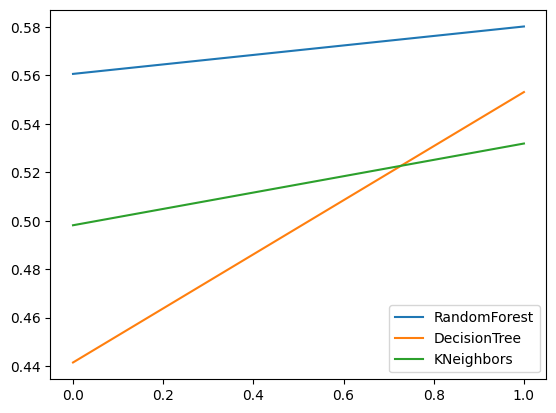

In [158]:
plt.plot(acc)
plt.legend(acc.columns)
plt.show()

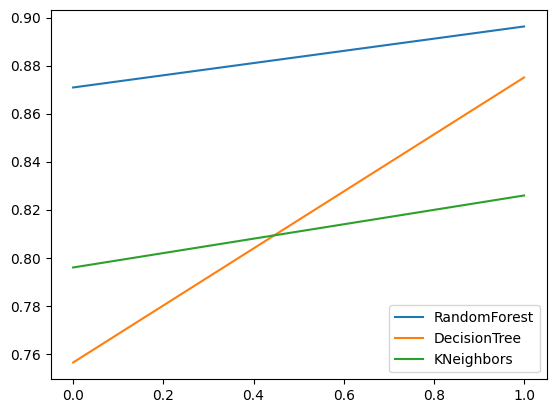

In [159]:
plt.plot(top10_acc)
plt.legend(top10_acc.columns)
plt.show()

**Lets test the model on unseen test data and evaluate the performance.**

In [160]:
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)

    #Evaluation
    print(f'Model: {model_name}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Top 10 Accuracy Score: {top_k_accuracy_score(y_test, model.predict_proba(X_test), k=10)}\n')

Model: RandomForest
Accuracy: 0.582014987510408
Top 10 Accuracy Score: 0.9929225645295587

Model: DecisionTree
Accuracy: 0.5553705245628643
Top 10 Accuracy Score: 0.9870940882597835

Model: KNeighbors
Accuracy: 0.5541215653621981
Top 10 Accuracy Score: 0.9754371357202332



**Based on the metrics Random Forest gives best results.**<br>
We will save the trained random forest model and encoder on drive using pickle so we can use it later for prediction.

In [161]:
# Saving model to pickle file
new_best_model = best_estimators['RandomForest']
with open("new_best_model_top10.pkl", "wb") as file:
    pickle.dump(new_best_model, file)

In [162]:
# Saving encoder to pickle file
with open("new_encoders.pkl", "wb") as file:
    pickle.dump(label_encoders, file)

In [ ]:
columns = list(X_train.columns)
# Save the names of columns to pickle file
with open("columns.pkl", "wb") as file:
    pickle.dump(columns, file)

**Now we will use the gradio for deployment of the model.**

In [ ]:
#Define the ExtendedLabelEncoder class.
class ExtendedLabelEncoder(LabelEncoder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._mapping_extended = {}
        self._inverse_mapping_extended = {}
        self._new_values = {}
        self._next_value = None

    def fit(self, X, y=None):
        super().fit(X)
        self._mapping_extended = {value: idx for idx, value in enumerate(self.classes_)}
        self._inverse_mapping_extended = {idx: value for idx, value in enumerate(self.classes_)}
        self._max_value = max(self._mapping_extended.values())
        self._next_value = self._max_value + 1

    def transform(self, X):
        transformed = []
        for x in X:
            if x in self._mapping_extended:
                transformed.append(self._mapping_extended[x])
            else:
                if x not in self._new_values:
                    self._new_values[x] = self._next_value
                    self._inverse_mapping_extended[self._next_value] = x
                    self._next_value += 1
                transformed.append(self._new_values[x])
        return transformed

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        return [self._inverse_mapping_extended[x] if x in self._inverse_mapping_extended else 'unknown' for x in X]

def predict_top_n_drivers(cars, drivers, grand_prix, year, start, qualify_pos, nationality, quali_mean, total_pts, top_finishers= 10):
    
    with open("columns.pkl", "rb") as file:
        columns = pickle.load(file)
    
    new_data = {}
    
    # Convert the parameters into the proper format
    cars = list(cars.split(","))
    drivers = list(drivers.split(","))
    grand_prix = [grand_prix] * len(cars)
    year = [int(year)] * len(cars)
    start = list(map(int, start.split(",")))
    qualify_pos = list(map(int, qualify_pos.split(",")))
    nationality = list(nationality.split(","))
    quali_mean = list(map(float, quali_mean.split(",")))
    total_pts = list(map(float, total_pts.split(",")))

    data = [cars, drivers, grand_prix, year, start, qualify_pos, nationality, quali_mean, total_pts]
    
    for k, v in zip(columns, data):
        new_data[k] = v

    new_data = pd.DataFrame(new_data)

    
    # Encode categorical features
    with open("new_encoders.pkl", "rb") as file:
        label_encoders = pickle.load(file)

    for col, le in label_encoders.items():
        new_data[col] = le.transform(new_data[col])

    # Load saved model
    with open("new_best_model_top10.pkl", "rb") as file:
        model = pickle.load(file)

    # Make probability predictions
    predictions = model.predict_proba(new_data)

    # Get the top 10 predictions
    predictions = np.delete(predictions, 10, 1) #delete last column as it has probability for positions 11 and above. We need top 10
    
    # Get the index of top 10 drivers
    idx =  np.argmax(predictions, axis= 0)

    encoded_drivers = new_data[pd.Series(new_data.index.values).isin(idx)]['Driver']
    decoded_drivers = label_encoders['Driver'].inverse_transform(encoded_drivers)

    return ", ".join(decoded_drivers)


with gr.Blocks() as demo:
    top_finishers = gr.Number(label='Mention Top number of finishers to Predict', value=10, interactive = False)
    cars = gr.Textbox(label='Cars Participating', placeholder='Write names of the cars separated by comma')
    drivers = gr.Textbox(label='Drivers', placeholder='Write Driver names separated by comma')
    grand_prix = gr.Textbox(label='Grand Prix', placeholder='Write Grand Prix name')
    year = gr.Number(label='Year')
    start = gr.Textbox(label='Starting Positions')
    qualify_pos = gr.Textbox(label='Qualifying Positions', placeholder='If disqualified or not participated enter -1')
    nationality = gr.Textbox(label='Nationalities', placeholder='Enter the nationalities of respective drivers')
    quali_mean = gr.Textbox(label='Average values of qualifying for respective drivers')
    total_pts = gr.Textbox(label='Total points collected by driver till now')

    inputs = [cars, drivers, grand_prix, year, start, qualify_pos, nationality, quali_mean, total_pts, top_finishers]
    output = gr.Textbox(label='The Predicted drivers are:')
    button = gr.Button("Submit")
    button.click(predict_top_n_drivers, inputs=inputs, outputs=output)

demo.launch()
